## Lab 3

### Part 3. HAR classification with raw data (2+ points)
__Disclaimer__: В данном задании придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%.

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

%matplotlib inline

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)).

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

In [ ]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
!unzip UCI-HAR-Dataset.zip

Archive:  UCI-HAR-Dataset.zip
   creating: UCI HAR Dataset/
  inflating: UCI HAR Dataset/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/UCI HAR Dataset/
  inflating: __MACOSX/UCI HAR Dataset/._.DS_Store  
  inflating: UCI HAR Dataset/activity_labels.txt  
  inflating: __MACOSX/UCI HAR Dataset/._activity_labels.txt  
  inflating: UCI HAR Dataset/features.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features.txt  
  inflating: UCI HAR Dataset/features_info.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features_info.txt  
  inflating: UCI HAR Dataset/README.txt  
  inflating: __MACOSX/UCI HAR Dataset/._README.txt  
   creating: UCI HAR Dataset/test/
   creating: UCI HAR Dataset/test/Inertial Signals/
  inflating: UCI HAR Dataset/test/Inertial Signals/body_acc_x_test.txt  
   creating: __MACOSX/UCI HAR Dataset/test/
   creating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/
  inflating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/._body_acc_x_test.txt  
  inflating: UCI HAR

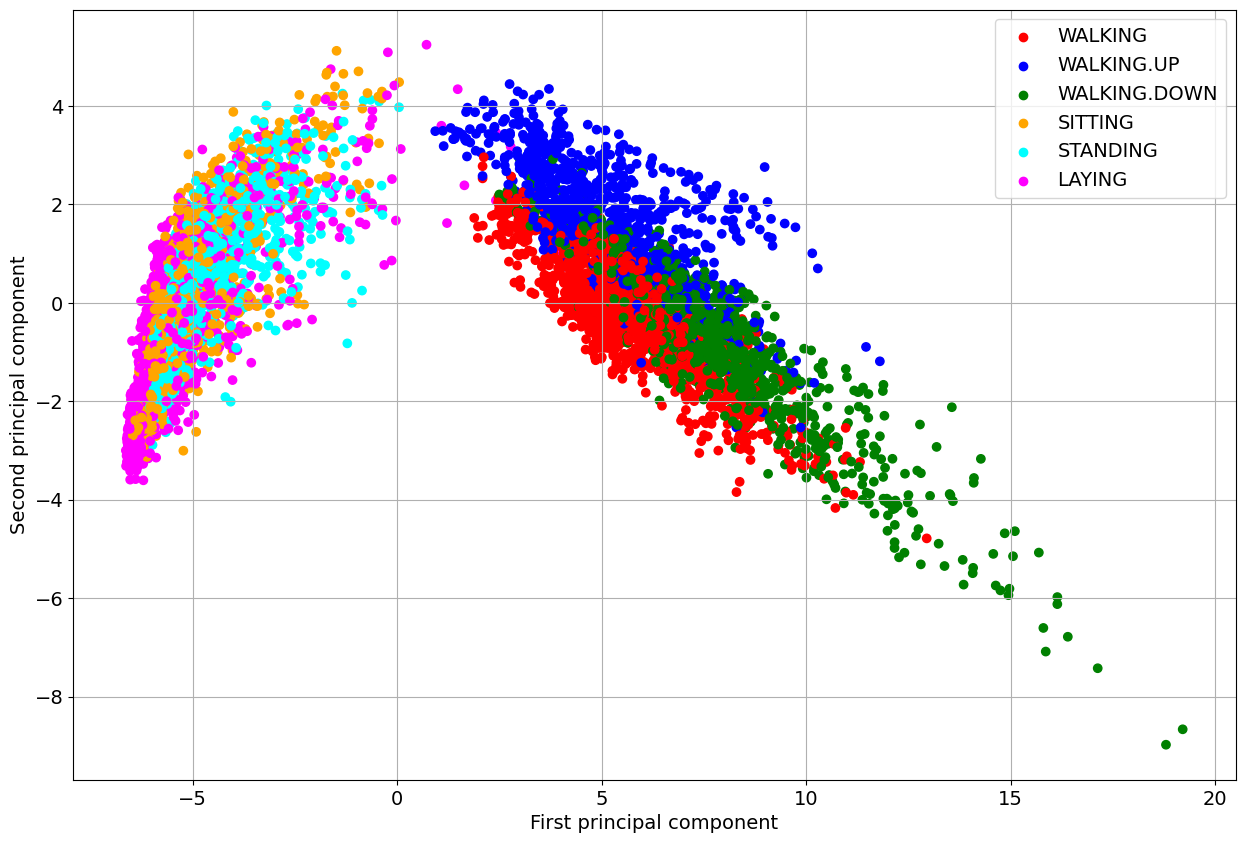

In [46]:
X_train_with_engineered_features = np.genfromtxt(os.path.join('UCI HAR Dataset', 'train', "X_train.txt"))
y_train = np.genfromtxt(os.path.join('UCI HAR Dataset', 'train', "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0],
                x[1],
                c=colors_list[idx],
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [47]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + 'UCI HAR Dataset/'
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []

    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()

    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()

    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [48]:
# Input Data

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__
Разбалловка следующая:
* $=$86% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

In [ ]:
import xgboost as xgb

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Установите device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

# class HARDataPreprocessor:
#     def __init__(self):
#         self.base_path = 'UCI HAR Dataset'

#     def preprocess(self):


class HARDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)


    def __getitem__(self, idx):
        return (self.features[idx], self.labels[idx])


class CNN1d(nn.Module):
    def __init__(self, in_channels=9, num_classes=6):
        super(CNN1d, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=32, kernel_size=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.3)
        )

        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.3)
        )

        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.3)
        )

        self.global_pooling = nn.AdaptiveAvgPool1d(1)

        self.fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.global_pooling(x)
        x = x.squeeze(-1)
        x = self.fc(x)

        return x


class ModelTrainer:
    def __init__(self, model, device):
        self.model = model.to(device)
        self.device = device
        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []

    def train_epoch(self, train_loader, n_epoch, criterion, opt):

        self.model.train()
        batch_loss = []
        correct = 0
        total = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
            y_pred = self.model(X_batch)
            y_batch = y_batch.squeeze().long()
            # print(f"Batch shapes - X: {X_batch.shape}, y_pred: {y_pred.shape}, y_batch: {y_batch.shape}")

            loss = criterion(y_pred, y_batch)

            if y_batch.dim() == 0:  # Если batch_size=1
                y_batch = y_batch.unsqueeze(0)

            _, predicted = torch.max(y_pred.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

            loss.backward()
            opt.step()
            opt.zero_grad()

            batch_loss.append(loss.item())

        return np.mean(batch_loss), 100. * correct / total

    def validate(self, val_loader, criterion):
        """Валидация модели"""
        self.model.eval()
        val_loss = []
        correct = 0
        total = 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)

                y_pred = self.model(X_batch)
                y_batch = y_batch.squeeze().long()
                loss = criterion(y_pred, y_batch)

                _, predicted = torch.max(y_pred.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()


                val_loss.append(loss.item())


        return np.mean(val_loss), 100. * correct / total


    def train(self, train_loader, val_loader, criterion, opt, num_epochs=50):

        for epoch in range(num_epochs):
            print(f'Training epoch #{epoch}')
            train_loss, train_acc = self.train_epoch(train_loader, epoch, criterion, opt)
            print(f'Finished epoch #{epoch}')

            val_loss, val_acc = self.validate(val_loader, criterion)

            self.train_losses.append(train_loss)
            self.val_accs.append(val_acc)
            self.val_losses.append(val_loss)
            self.train_accs.append(train_acc)

            if (epoch + 1) % 5 == 0 or epoch == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}]')
                print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
                print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
                print("-" * 40)

    def evaluate(self, test_loader):
        """Оценка модели на тестовых данных"""
        self.model.eval()
        all_preds = []
        all_targets = []
        test_loss = []

        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(self.device)
                y_batch = y_batch.to(self.device)

                y_pred = self.model(X_batch)
                y_batch = y_batch.squeeze().long()

                loss = criterion(y_pred, y_batch)
                test_loss.append(loss.item())

                _, predicted = y_pred.max(1)

                all_preds.extend(predicted.cpu().numpy())
                all_targets.extend(y_batch.cpu().numpy())

        avg_test_loss = np.mean(test_loss)
        test_accuracy = accuracy_score(all_targets, all_preds)

        return all_preds, all_targets, avg_test_loss, test_accuracy

    def plot_training_history(self):
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        axes[0].plot(self.train_losses, label='Train Loss', linewidth=2)
        axes[0].plot(self.val_losses, label='Val Loss', linewidth=2)
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Training and Validation Loss')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        axes[1].plot(self.train_accs, label='Train Accuracy', linewidth=2)
        axes[1].plot(self.val_accs, label='Val Accuracy', linewidth=2)
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy (%)')
        axes[1].set_title('Training and Validation Accuracy')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        best_val_acc = max(self.val_accs)
        best_epoch = self.val_accs.index(best_val_acc)
        axes[1].axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5)
        axes[1].annotate(f'Best: {best_val_acc:.2f}%',
                        xy=(best_epoch, best_val_acc),
                        xytext=(best_epoch + 2, best_val_acc - 5),
                        arrowprops=dict(arrowstyle='->', color='red'))

        plt.tight_layout()
        plt.show()

Используемое устройство: cpu


Training epoch #0
Finished epoch #0
Epoch [1/100]
Train Loss: 1.7202, Train Acc: 31.94%
Val Loss: 1.7657, Val Acc: 20.63%
----------------------------------------
Training epoch #1
Finished epoch #1
Training epoch #2
Finished epoch #2
Training epoch #3
Finished epoch #3
Training epoch #4
Finished epoch #4
Epoch [5/100]
Train Loss: 1.0669, Train Acc: 55.95%
Val Loss: 1.2055, Val Acc: 55.56%
----------------------------------------
Training epoch #5
Finished epoch #5
Training epoch #6
Finished epoch #6
Training epoch #7
Finished epoch #7
Training epoch #8
Finished epoch #8
Training epoch #9
Finished epoch #9
Epoch [10/100]
Train Loss: 0.7236, Train Acc: 66.67%
Val Loss: 0.7683, Val Acc: 76.19%
----------------------------------------
Training epoch #10
Finished epoch #10
Training epoch #11
Finished epoch #11
Training epoch #12
Finished epoch #12
Training epoch #13
Finished epoch #13
Training epoch #14
Finished epoch #14
Epoch [15/100]
Train Loss: 0.4538, Train Acc: 84.52%
Val Loss: 0.357

AttributeError: 'ModelTrainer' object has no attribute 'model_name'

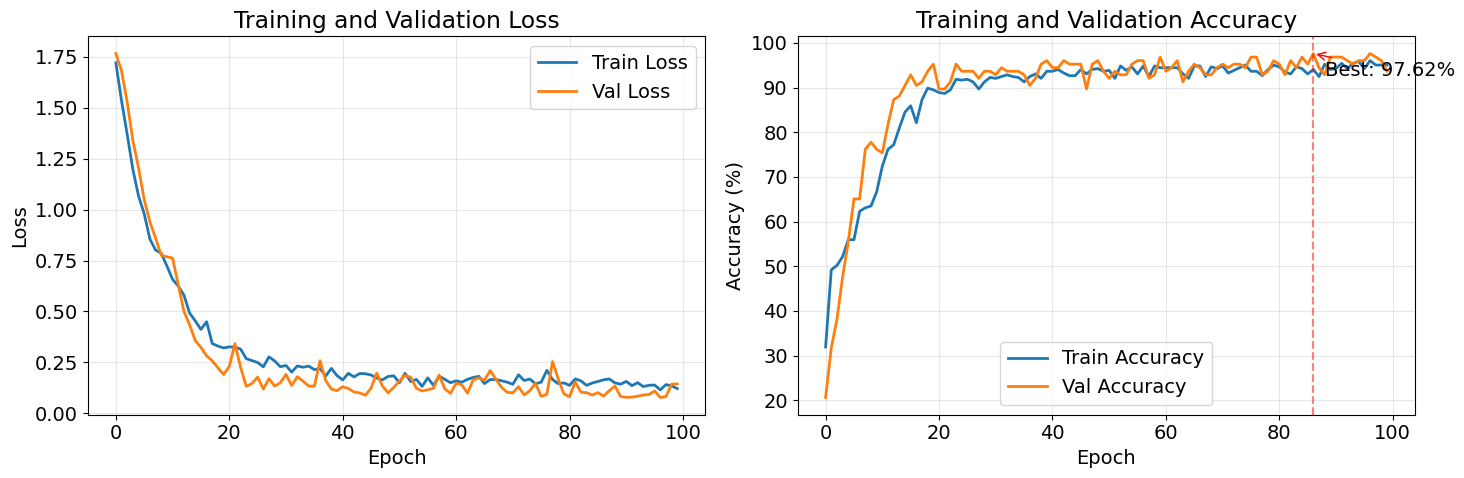

In [72]:
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
NUM_EPOCHS = 100

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
train_dataset = HARDataset(X_train, y_train)
val_dataset = HARDataset(X_val, y_val)
test_dataset = HARDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = CNN1d()
trainer = ModelTrainer(model, 'cpu')

criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
trainer.train(
    train_loader, val_loader, criterion, opt, num_epochs=NUM_EPOCHS
)

print('Приступаем к тестированию')
y_pred, y_true, test_loss, test_accuracy = trainer.evaluate(test_loader)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

trainer.plot_training_history()

### Часть 4. Optional. Dogs classification.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$96% - 2 points
* $>=$85% - 1.5 points
* $>=$70% - 0.75 points